In [114]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
from sklearn.impute import SimpleImputer


In [115]:
data = pd.read_csv('train_dataset_final1.csv')
data.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [116]:
# Find columns with missing values
missing_cols = [col for col in data.columns if data[col].isnull().any()]

# Fill missing values with median and count filled values
for col in missing_cols:
    num_missing = data[col].isnull().sum()
    median = data[col].median()
    data[col] = data[col].fillna(median)
    print(f"Filled {num_missing} missing values in column '{col}' with median value {median}.")

Filled 126 missing values in column 'age' with median value 34.0.


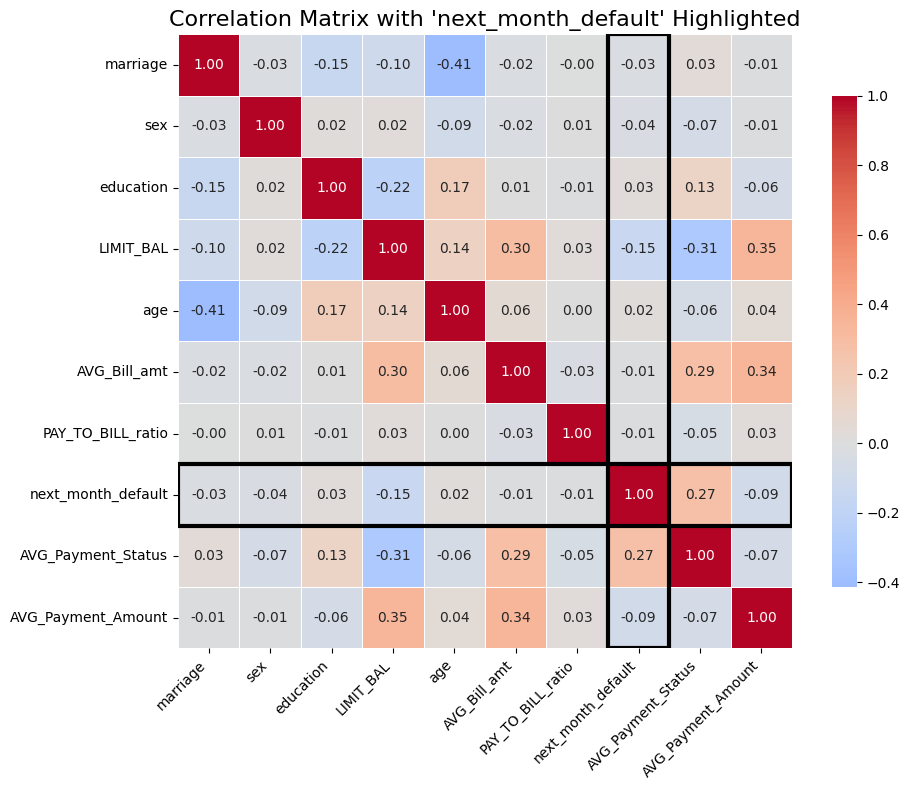

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy original data
df_corr = data.copy()

# Create averaged features
df_corr['AVG_Bill_amt'] = df_corr[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
df_corr['AVG_Payment_Status'] = df_corr[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].mean(axis=1)
df_corr['AVG_Payment_Amount'] = df_corr[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)

# Drop unnecessary columns
cols_to_drop = (
    ['Customer_ID'] +
    [f'Bill_amt{i}' for i in range(1, 7)] +
    ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'] +
    [f'pay_amt{i}' for i in range(1, 7)]
)
df_corr_small = df_corr.drop(columns=cols_to_drop, errors='ignore')

# Correlation matrix
corr_matrix = df_corr_small.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                 center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Highlight 'next_month_default' column and row
highlight_label = 'next_month_default'
if highlight_label in corr_matrix.columns:
    idx = list(corr_matrix.columns).index(highlight_label)

    # Draw rectangles to highlight the row and column
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(corr_matrix), fill=False, edgecolor='black', lw=3))
    ax.add_patch(plt.Rectangle((0, idx), len(corr_matrix), 1, fill=False, edgecolor='black', lw=3))

plt.title("Correlation Matrix with 'next_month_default' Highlighted", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [118]:
from sklearn.preprocessing import StandardScaler

# Select features and target variable
X = data.drop(['Customer_ID', 'next_month_default'], axis=1)
y = data['next_month_default']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #converted to array

# X_scaled is now ready for linear regression

In [119]:
n = X_scaled.shape[0]
split = int(n * 0.8)
indices = np.random.RandomState(42).permutation(n)
train_idx, test_idx = indices[:split], indices[split:]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y.values[train_idx], y.values[test_idx]

In [120]:
# Add bias term
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Fit linear regression (normal equation)
w = np.linalg.inv(X_train_b.T @ X_train_b) @ (X_train_b.T @ y_train.reshape(-1, 1))

# Predict and threshold at 0.5
y_pred = X_test_b @ w
y_pred_class = (y_pred >= 0.5).astype(int)

# Accuracy
acc = (y_pred_class.flatten() == y_test).mean()
print(f"Test accuracy: {acc:.4f}")

Test accuracy: 0.8133


In [121]:
# Prepare features and target
X = data.drop(['Customer_ID', 'next_month_default'], axis=1).values
y = data['next_month_default'].values.reshape(-1, 1)

# Standardize features (manual)
mean = X.mean(axis=0)
std = X.std(axis=0)
X_scaled = (X - mean) / std

# Add bias term
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Ridge regression closed-form solution
def ridge_weights(X, y, lmbd):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # Don't regularize bias
    return np.linalg.inv(X.T @ X + lmbd * I) @ (X.T @ y)

# Cross-validation to find best lambda
lambdas = np.logspace(-3, 3, 10)
best_acc = 0
best_lmbd = None

for lmbd in lambdas:
    # 5-fold CV
    fold_size = X_train.shape[0] // 5
    accs = []
    for fold in range(5):
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size if fold < 4 else X_train.shape[0]
        val_idx = np.arange(val_start, val_end)
        tr_idx = np.setdiff1d(np.arange(X_train.shape[0]), val_idx)
        X_tr, y_tr = X_train_b[tr_idx], y_train[tr_idx]
        X_val, y_val = X_train_b[val_idx], y_train[val_idx]
        w = ridge_weights(X_tr, y_tr, lmbd)
        y_pred = X_val @ w
        y_pred_class = (y_pred >= 0.5).astype(int)
        acc = (y_pred_class == y_val).mean()
        accs.append(acc)
    mean_acc = np.mean(accs)
    if mean_acc > best_acc:
        best_acc = mean_acc
        best_lmbd = lmbd

# Train on full train set with best lambda
w_best = ridge_weights(X_train_b, y_train, best_lmbd)

# Predict on test set
y_pred_test = X_test_b @ w_best
y_pred_test_class = (y_pred_test >= 0.5).astype(int)
test_acc = (y_pred_test_class == y_test).mean()

print(f"Best lambda: {best_lmbd}")
print(f"Test accuracy: {test_acc:.4f}")

Best lambda: 0.001
Test accuracy: 0.8133


Regression was not overfitting.

In [ ]:
import numpy as np
# Helper functions for entropy and information gain
def entropy(y):
    """Compute entropy of label array y (binary classification)."""
    if len(y) == 0:
        return 0
    p1 = np.mean(y)
    p0 = 1 - p1
    if p1 == 0 or p1 == 1:
        return 0
    return -p0 * np.log2(p0) - p1 * np.log2(p1)

def info_gain(y, y_left, y_right):
    """Compute information gain from a split."""
    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)
    if n_left == 0 or n_right == 0:
        return 0
    return entropy(y) - (n_left / n) * entropy(y_left) - (n_right / n) * entropy(y_right)

# Decision tree node class
class Node:
    def __init__(self, depth=0, max_depth=5):
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.pred = None
        self.depth = depth
        self.max_depth = max_depth

    def fit(self, X, y):
        # If pure or max depth reached, make leaf
        if len(set(y)) == 1 or self.depth >= self.max_depth:
            self.pred = np.round(np.mean(y))
            return

        n_samples, n_features = X.shape
        best_gain = -1
        best_feat = None
        best_thresh = None

        # Try all features and thresholds
        for feat in range(n_features):
            thresholds = np.unique(X[:, feat])
            for thresh in thresholds:
                left_idx = X[:, feat] <= thresh
                right_idx = X[:, feat] > thresh
                if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
                    continue
                gain = info_gain(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat
                    best_thresh = thresh

        if best_gain == -1:
            self.pred = np.round(np.mean(y))
            return

        self.feature = best_feat
        self.threshold = best_thresh

        left_idx = X[:, self.feature] <= self.threshold
        right_idx = X[:, self.feature] > self.threshold

        self.left = Node(depth=self.depth + 1, max_depth=self.max_depth)
        self.left.fit(X[left_idx], y[left_idx])
        self.right = Node(depth=self.depth + 1, max_depth=self.max_depth)
        self.right.fit(X[right_idx], y[right_idx])

    def predict_one(self, x):
        if self.pred is not None:
            return self.pred
        if x[self.feature] <= self.threshold:
            return self.left.predict_one(x)
        else:
            return self.right.predict_one(x)

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

# Prepare data (use X and y from previous cells

# Train decision tree
tree = Node(max_depth=5)
tree.fit(X_train, y_train.flatten())

# Predict
y_pred_tree = tree.predict(X_test)
acc_tree = np.mean(y_pred_tree == y_test.flatten())
print(f"Decision tree test accuracy: {acc_tree:.4f}")

In [123]:
# # Simple Random Forest implementation (no sklearn)
# # We'll use the Node class from the previous cell as our decision tree

# class SimpleRandomForest:
#     def __init__(self, n_estimators=10, max_depth=5, max_features='sqrt', random_state=None):
#         self.n_estimators = n_estimators
#         self.max_depth = max_depth
#         self.max_features = max_features
#         self.trees = []
#         self.features_list = []
#         self.random_state = np.random.RandomState(random_state)

#     def _get_max_features(self, n_features):
#         if self.max_features == 'sqrt':
#             return max(1, int(np.sqrt(n_features)))
#         elif self.max_features == 'log2':
#             return max(1, int(np.log2(n_features)))
#         elif isinstance(self.max_features, int):
#             return self.max_features
#         else:
#             return n_features

#     def fit(self, X, y):
#         n_samples, n_features = X.shape
#         for i in range(self.n_estimators):
#             # Bootstrap sample
#             idx = self.random_state.choice(n_samples, n_samples, replace=True)
#             X_sample = X[idx]
#             y_sample = y[idx].flatten()
#             # Random feature selection
#             max_feats = self._get_max_features(n_features)
#             feats = self.random_state.choice(n_features, max_feats, replace=False)
#             self.features_list.append(feats)
#             # Train tree
#             tree = Node(max_depth=self.max_depth)
#             tree.fit(X_sample[:, feats], y_sample)
#             self.trees.append(tree)

#     def predict(self, X):
#         # Aggregate predictions from all trees
#         preds = []
#         for tree, feats in zip(self.trees, self.features_list):
#             pred = tree.predict(X[:, feats])
#             preds.append(pred)
#         preds = np.array(preds)  # shape: (n_estimators, n_samples)
#         # Majority vote
#         maj_vote = np.round(np.mean(preds, axis=0))
#         return maj_vote

# # Train and evaluate
# rf = SimpleRandomForest(n_estimators=10, max_depth=5, max_features='sqrt', random_state=42)
# rf.fit(X_train, y_train.flatten())
# y_pred_rf = rf.predict(X_test)
# acc_rf = np.mean(y_pred_rf == y_test.flatten())
# print(f"Random forest test accuracy: {acc_rf:.4f}")

In [124]:
# Train and evaluate RandomForestClassifier from sklearn
rf_lib = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=55)
rf_lib.fit(X_train, y_train.flatten())
y_pred_rf_lib = rf_lib.predict(X_test)
acc_rf_lib = np.mean(y_pred_rf_lib == y_test.flatten())
print(f"RandomForestClassifier (sklearn) test accuracy: {acc_rf_lib:.4f}")

RandomForestClassifier (sklearn) test accuracy: 0.8402


In [125]:
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 3. Create and train LightGBM classifier
model = lgb.LGBMClassifier(n_estimators=120, max_depth=5, random_state=55)
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Evaluate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"LightGBM Accuracy: {acc:.4f}")


[LightGBM] [Info] Number of positive: 3836, number of negative: 16361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3779
[LightGBM] [Info] Number of data points in the train set: 20197, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.189929 -> initscore=-1.450470
[LightGBM] [Info] Start training from score -1.450470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [126]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 3. Create and train XGBoost classifier
model = xgb.XGBClassifier(n_estimators=90, max_depth=5, random_state=55, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Evaluate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {acc:.4f}")


XGBoost Accuracy: 0.8366


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:43:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


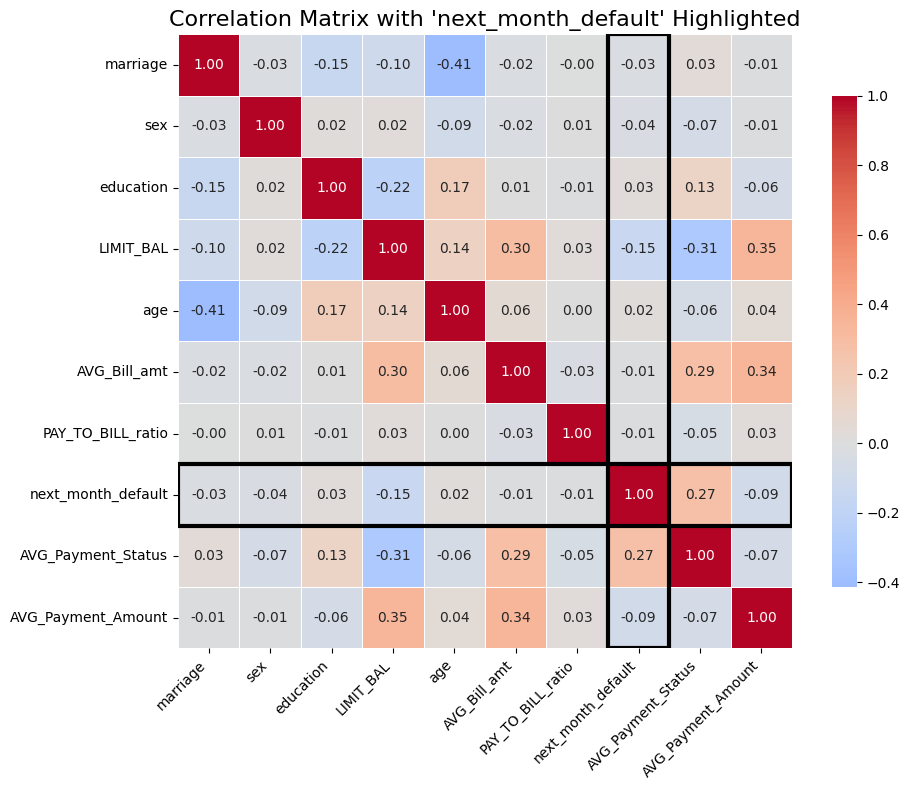

In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy original data
df_corr = data.copy()

# Create averaged features
df_corr['AVG_Bill_amt'] = df_corr[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
df_corr['AVG_Payment_Status'] = df_corr[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].mean(axis=1)
df_corr['AVG_Payment_Amount'] = df_corr[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)

# Drop unnecessary columns
cols_to_drop = (
    ['Customer_ID'] +
    [f'Bill_amt{i}' for i in range(1, 7)] +
    ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'] +
    [f'pay_amt{i}' for i in range(1, 7)]
)
df_corr_small = df_corr.drop(columns=cols_to_drop, errors='ignore')

# Correlation matrix
corr_matrix = df_corr_small.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                 center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Highlight 'next_month_default' column and row
highlight_label = 'next_month_default'
if highlight_label in corr_matrix.columns:
    idx = list(corr_matrix.columns).index(highlight_label)

    # Draw rectangles to highlight the row and column
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(corr_matrix), fill=False, edgecolor='black', lw=3))
    ax.add_patch(plt.Rectangle((0, idx), len(corr_matrix), 1, fill=False, edgecolor='black', lw=3))

plt.title("Correlation Matrix with 'next_month_default' Highlighted", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Exclude specified features
exclude_cols = ['marriage', 'sex', 'education', 'age', 'PAY_TO_BILL_ratio','AVG_Bill_amt'] + \
               [f'Bill_amt{i}' for i in range(1, 7)]

# Keep only relevant features
feature_cols = [col for col in data.columns if col not in exclude_cols + ['next_month_default', 'Customer_ID']]
X_reduced = data[feature_cols]
y_reduced = data['next_month_default']

# Step 2: Train-test split (80-20)
X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

# Step 3: Train Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=55)
model.fit(X_reduced_train, y_reduced_train)

# Step 4: Predict and evaluate
y_reduced_pred = model.predict(X_reduced_test)
acc = accuracy_score(y_reduced_test, y_reduced_pred)
print(f"Random Forest Accuracy (selected features): {acc:.4f}")


Random Forest Accuracy (selected features): 0.8392


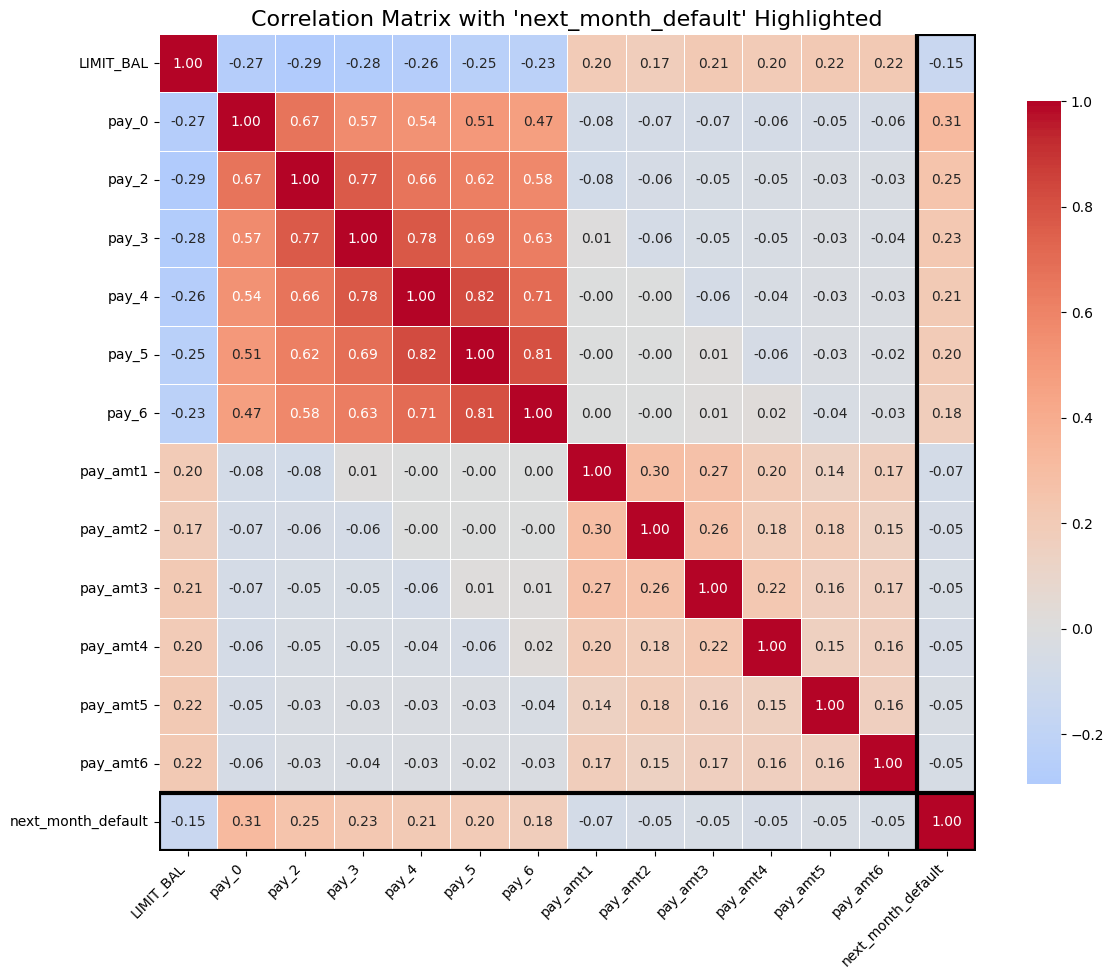

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Define columns to exclude
exclude_cols = ['marriage', 'sex', 'education', 'age', 'PAY_TO_BILL_ratio','AVG_Bill_amt'] + \
               [f'Bill_amt{i}' for i in range(1, 7)] + ['Customer_ID']

# Step 2: Select remaining features (including target)
df_corr = data.drop(columns=exclude_cols, errors='ignore')

# Step 3: Compute correlation matrix
corr_matrix = df_corr.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                 center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Step 5: Highlight 'next_month_default' row and column
target_col = 'next_month_default'
if target_col in corr_matrix.columns:
    idx = list(corr_matrix.columns).index(target_col)

    # Draw black rectangle around the column
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(corr_matrix), fill=False, edgecolor='black', lw=3))
    # Draw black rectangle around the row
    ax.add_patch(plt.Rectangle((0, idx), len(corr_matrix), 1, fill=False, edgecolor='black', lw=3))

plt.title("Correlation Matrix with 'next_month_default' Highlighted", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


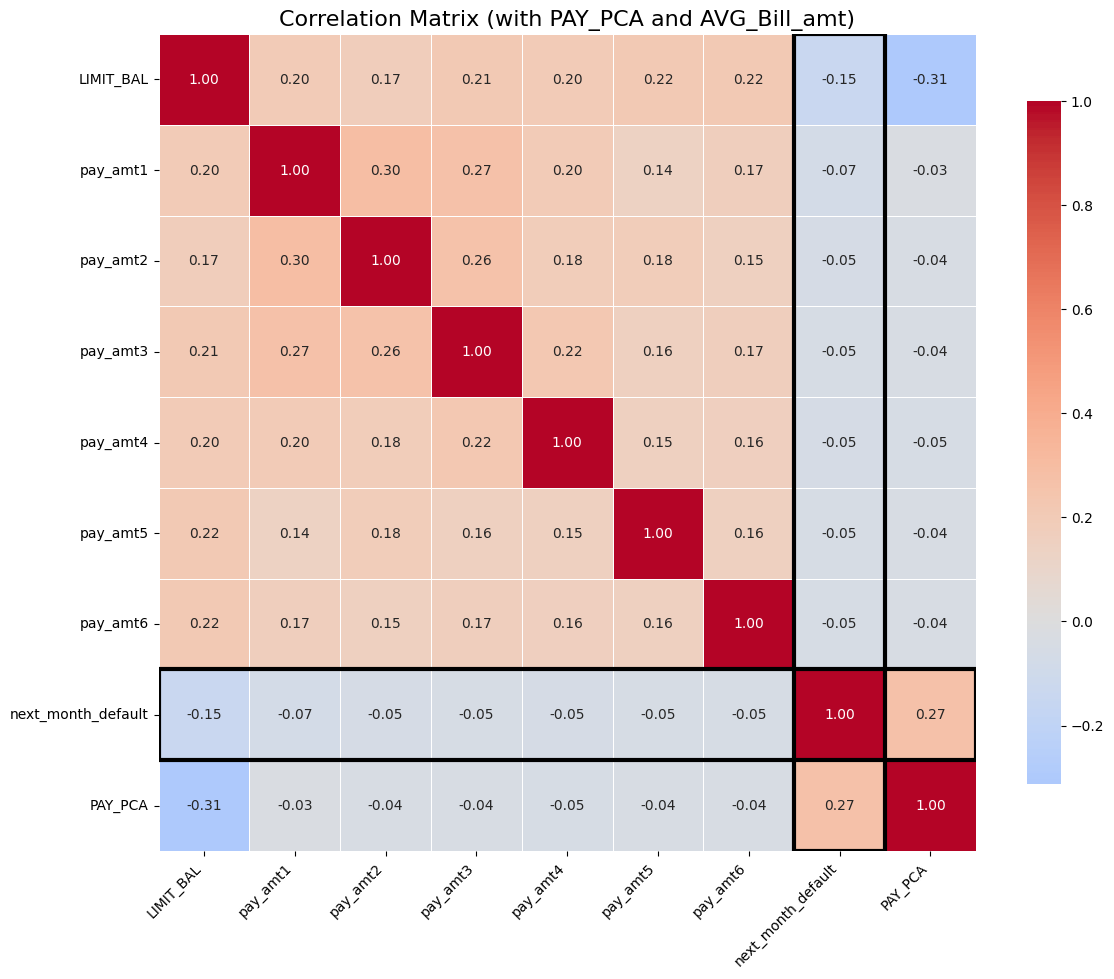

In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Create a copy of the original DataFrame
df_corr = data.copy()

# Step 2: Create AVG_Bill_amt
df_corr['AVG_Bill_amt'] = df_corr[[f'Bill_amt{i}' for i in range(1, 7)]].mean(axis=1)

# Step 3: Create PAY_PCA from pay_0 to pay_6 (excluding pay_1 as per original features)
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
scaler = StandardScaler()
pay_scaled = scaler.fit_transform(df_corr[pay_cols])
pca = PCA(n_components=1)
df_corr['PAY_PCA'] = pca.fit_transform(pay_scaled)

# Step 4: Drop excluded features
exclude_cols = ['Customer_ID', 'marriage', 'sex', 'education', 'age', 'PAY_TO_BILL_ratio','AVG_Bill_amt'] + \
               [f'Bill_amt{i}' for i in range(1, 7)] + pay_cols
df_corr = df_corr.drop(columns=exclude_cols, errors='ignore')

# Step 5: Correlation matrix
corr_matrix = df_corr.corr()

# Step 6: Plot heatmap with highlight on target
plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                 center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

# Highlight 'next_month_default' with black box
target_col = 'next_month_default'
if target_col in corr_matrix.columns:
    idx = list(corr_matrix.columns).index(target_col)
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(corr_matrix), fill=False, edgecolor='black', lw=3))
    ax.add_patch(plt.Rectangle((0, idx), len(corr_matrix), 1, fill=False, edgecolor='black', lw=3))

plt.title("Correlation Matrix (with PAY_PCA and AVG_Bill_amt)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Prepare feature set and label from df_corr
Xr = df_corr.drop(columns=['next_month_default'])
yr = df_corr['next_month_default']

# Step 2: Train-test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)


features_used = list(Xr.columns)
print("Feature List:", features_used)



Feature List: ['LIMIT_BAL', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'PAY_PCA']


In [132]:
# Step 3: Train Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=55)
model.fit(Xr_train, yr_train)

# Step 4: Evaluate
yr_pred = model.predict(Xr_test)
acc = accuracy_score(yr_test, yr_pred)
print(f"Random Forest Accuracy (correlation-matrix features only): {acc:.4f}")

Random Forest Accuracy (correlation-matrix features only): 0.8214


In [138]:
# Simple Random Forest implementation (no sklearn)
# We'll use the Node class from the previous cell as our decision tree

class SimpleRandomForest:
    def __init__(self, n_estimators=10, max_depth=5, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.features_list = []
        self.random_state = np.random.RandomState(random_state)

    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return max(1, int(np.sqrt(n_features)))
        elif self.max_features == 'log2':
            return max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            return self.max_features
        else:
            return n_features

    def fit(self, X, y):
        n_samples, n_features = X.shape
        for i in range(self.n_estimators):
            # Bootstrap sample
            idx = self.random_state.choice(n_samples, n_samples, replace=True)
            X_sample = X[idx]
            y_sample = y[idx].flatten()
            # Random feature selection
            max_feats = self._get_max_features(n_features)
            feats = self.random_state.choice(n_features, max_feats, replace=False)
            self.features_list.append(feats)
            # Train tree
            tree = Node(max_depth=self.max_depth)
            tree.fit(X_sample[:, feats], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Aggregate predictions from all trees
        preds = []
        for tree, feats in zip(self.trees, self.features_list):
            pred = tree.predict(X[:, feats])
            preds.append(pred)
        preds = np.array(preds)  # shape: (n_estimators, n_samples)
        # Majority vote
        maj_vote = np.round(np.mean(preds, axis=0))
        return maj_vote

# Train and evaluate
# Corrected training and evaluation code
rf = SimpleRandomForest(n_estimators=10, max_depth=5, max_features='sqrt', random_state=42)
rf.fit(Xr_train.values, yr_train.values)  # .values converts Series/DataFrame to NumPy
yr_pred_rf = rf.predict(Xr_test.values)
acc_rf = np.mean(yr_pred_rf == yr_test.values)
print(f"Random forest test accuracy: {acc_rf:.4f}")


Random forest test accuracy: 0.8109
